<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 4: Cross validation</h2></center>
<br>

In this tutorial we go back to the K-nearest neighbours regression method and the credit dataset to introduce model selection into the data analysis process. By using cross validation, we can pick the number of neighbours before generating predictions for the test data. 

<a class="buttom" href="#Data processing">Data processing</a> <br>
<a class="buttom" href="#KNN-regression-performance">KNN regression test performance</a> <br>
<a class="buttom" href="#Cross-validation">Cross validation</a> <br>
<a class="buttom" href="#Applying-cross-validation-to-KNN">Applying cross validation to KNN</a> <br>
<a class="buttom" href="#Adding-Predictors">Adding predictors</a> <br>
<a class="buttom" href="#Computational-considerations">Computational considerations</a> <br>
<a class="buttom" href="#The-next-step">The next step</a> <br>
<a class="buttom" href="#Exercise">Exercise</a> <br>


This notebook relies on the following imports throughout. We will load new packages and functions in context to make clear what we are using them for. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook') 

###Data processing

We start by loading the dataset in the same way as before. 

In [2]:
data=pd.read_csv('credit.csv', index_col='Obs')
data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


This time, I will do some additional processing to create dummy variables. 

In [3]:
data['Male']=(data['Gender'] ==' Male').astype(int)
data['Student']=(data['Student'] =='Yes').astype(int)
data['Married']=(data['Married'] =='Yes').astype(int)
data['Caucasian']=(data['Ethnicity'] =='Caucasian').astype(int)
data['Asian']=(data['Ethnicity'] =='Asian').astype(int)
data=data.loc[:, data.dtypes!='object'] # discards the columns that are not numerical
data=data.drop('Rating', axis=1) # dropping rating because it is collinear with limit, as we saw before
data.head()

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
1,14.891,3606,2,34,11,0,1,333,1,1,0
2,106.025,6645,3,82,15,1,1,903,0,0,1
3,104.593,7075,4,71,11,0,0,580,1,0,1
4,148.924,9504,3,36,11,0,0,964,0,0,1
5,55.882,4897,2,68,16,0,1,331,1,1,0


Our discussion of the random number generator state from last time becomes useful as we can now get the same training-test split as before. 

In [4]:
train = data.sample(frac=0.7, random_state=1)
test = data[data.index.isin(train.index)==False]

In [5]:
train.head()

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
399,37.728,2525,1,44,13,0,1,0,1,1,0
126,27.578,2531,1,34,15,0,1,0,0,1,0
329,41.192,3673,3,54,16,0,1,121,0,1,0
340,149.316,10278,1,80,16,0,0,1107,1,0,0
173,76.348,4697,4,60,18,0,0,108,1,0,1


###KNN regression test performance

Picking up from where we left, let's have a look at the solutions for the exercises from Tutorial 2. 

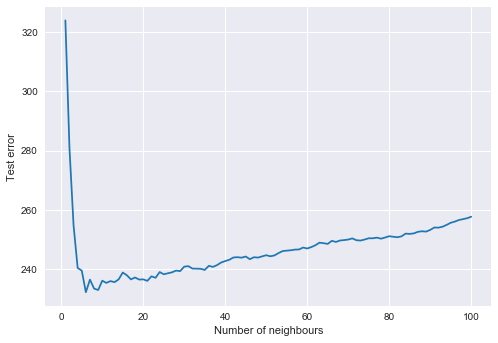

Lowest test error: K = 6


In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

neighbours=np.arange(1, 101)
test_rmse = []
for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors = k) 
    knn.fit(train[['Limit']], train['Balance'])
    predictions = knn.predict(test[['Limit']])
    rmse = np.sqrt(mean_squared_error(test['Balance'], predictions))
    test_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, test_rmse, color='#1F77B4')
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Test error')
plt.show()

print('Lowest test error: K = {}'.format(1 + np.argmin(test_rmse)))

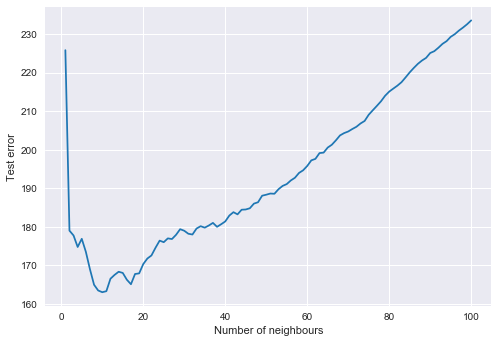

Lowest test error: K = 10


In [7]:
predictors=['Limit','Income']

neighbours=np.arange(1, 101)
test_rmse = []
for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors= k,  metric='mahalanobis', metric_params={'V': train[predictors].cov()}) 
    knn.fit(train[predictors], train['Balance'])
    predictions = knn.predict(test[predictors])
    rmse = np.sqrt(mean_squared_error(test['Balance'], predictions))
    test_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, test_rmse, color='#1F77B4')
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Test error')
plt.show()
                                   
print('Lowest test error: K = {}'.format(1 + np.argmin(test_rmse)))

Therefore, K=6 neighbours has the best test performance for the model with only limit as a predictor, and K=10 has the best test RMSE for the model with limit and income as predictors. We can see that in this second case, the test performance deteriorates sharply as we move away the optimal number of neighbours.

However, in practice we need to select the number of neighbours before taking the model to the test data. Are we able to identify based on the training data only that K around 6 and 7 is a good choice? To answer this question, we turn to cross validation.

###Cross validation

The general procedure for computing the cross validation errors is the following: 

1. Set a cross validation iterator. This will set the number of folds and specify which observations are each fold. 
2. Specify the model (without training it).
3. Use the [<TT>cross_validation_score</TT>](http://scikit-learn.org/stable/modules/model_evaluation.html) function to compute the cross validation errors. The output is the score for each fold. 

We will do this take it step by step. Suppose that we want to do 10-fold cross validation. The syntax for the [K-Fold CV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) iterator is as follows. 

In [8]:
from sklearn.model_selection import KFold
kf=KFold(10) 
# Syntax: KFold(number of folds, shuffle=True/False, random_state = a number, if shuffling)


By default, the shuffle option is <TT>False</TT>. That splits the data into folds according to the order of the observations, without randomisation. Setting it <TT>True</TT> splits the data randomly. It turns out that when we generated the training data, the function already returned a random permutation of the observations, so that it would be unnecessary to shuffle again here. 

For leave-one-out CV there is not split. Remember that LOOCV is equivalent to K-Fold CV with K equal to the size of the training sample.

In [9]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

We now compute the results for each fold, using the the 10-fold CV iterator. 

In [10]:
from sklearn.model_selection import cross_val_score

# Method
knn = KNeighborsRegressor(n_neighbors= 5) 

# Syntax: cross_val_score(method, predictors, response, cv = number of folds, scoring = scoring function)
scores = cross_val_score(knn, train[['Limit']], train['Balance'], cv=kf, scoring = 'neg_mean_squared_error')

print(scores)

[ -77897.08714286 -122744.42571429  -45361.16142857  -14631.97857143
  -28697.30142857  -51502.29142857  -80393.41142857  -50706.58142857
  -30731.23571429  -12061.44857143]


**The scoring in scikit-learn follows the convention that higher score values are better than lower values**. This is why the argument in the function is the negative mean squared error . The scikit-learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. You should save this for future reference.

Often, the syntax is simplified by the fact that each method in sci-kit learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [KNN regression the default scoring is the r-squared](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor), allowing us to interpret the output below. 

In [11]:
scores = cross_val_score(knn, train[['Limit']], train['Balance'], cv=kf)
print(scores)

[ 0.66456153  0.54011848  0.80810047  0.91623641  0.84439011  0.66948834
  0.65190653  0.80374385  0.88182998  0.9219122 ]


Another option is to create a scorer using [<TT>make_scorer</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer) function. In a general situation, we can then provide the same function that we we use for model evaluation.

In [12]:
from sklearn.metrics import make_scorer
scorer = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(knn, train[['Limit']], train['Balance'], cv=kf, scoring = scorer)
print(scores)

[ -77897.08714286 -122744.42571429  -45361.16142857  -14631.97857143
  -28697.30142857  -51502.29142857  -80393.41142857  -50706.58142857
  -30731.23571429  -12061.44857143]


Finally, in this case we could directly specify the number of folds instead of the iterator. The reason we started with the iterator is so that you know the full procedure.

In [13]:
scores = cross_val_score(knn, train[['Limit']], train['Balance'], cv=10,  scoring = 'neg_mean_squared_error')
print(scores)

[ -77897.08714286 -122744.42571429  -45361.16142857  -14631.97857143
  -28697.30142857  -51502.29142857  -80393.41142857  -50706.58142857
  -30731.23571429  -12061.44857143]


###Applying cross validation

In this section, we add the cross validation errors to the plots from before.

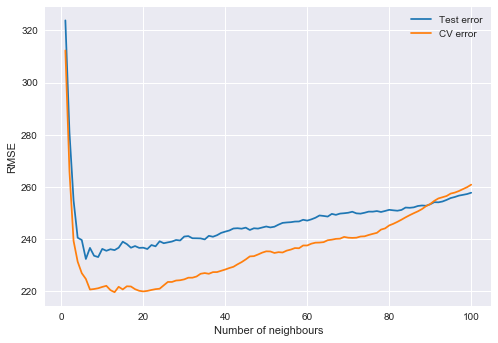

Lowest CV error: K = 13
Lowest test error: K = 6


In [14]:
neighbours=np.arange(1, 101)
test_rmse = []
cv_rmse = []
for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors= k) 
    scores = cross_val_score(knn, train[['Limit']], train['Balance'], cv=10, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores)) # taking the average MSE across folds, then taking the square root
    cv_rmse.append(rmse)
    knn.fit(train[['Limit']], train['Balance'])
    predictions = knn.predict(test[['Limit']])
    rmse = np.sqrt(mean_squared_error(test['Balance'], predictions))
    test_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, test_rmse, color='#1F77B4', label='Test error')
ax.plot(neighbours, cv_rmse, color='#FF7F0E', label='CV error')
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()
  
print('Lowest CV error: K = {}'.format(1 + np.argmin(cv_rmse)))   
print('Lowest test error: K = {}'.format(1 + np.argmin(test_rmse)))

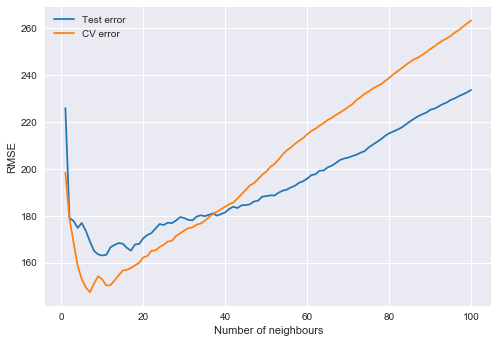

Lowest CV error: K = 7
Lowest test error: K = 10


In [15]:
predictors=['Limit','Income']

neighbours=np.arange(1, 101)
test_rmse = []
cv_rmse = []
for k in neighbours: 
    knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': train[predictors].cov()}) 
    scores = cross_val_score(knn, train[predictors], train['Balance'], cv=10, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores)) # taking the average MSE across folds, then taking the square root
    cv_rmse.append(rmse)
    knn.fit(train[predictors], train['Balance'])
    predictions = knn.predict(test[predictors])
    rmse = np.sqrt(mean_squared_error(test['Balance'], predictions))
    test_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, test_rmse, color='#1F77B4', label='Test error')
ax.plot(neighbours, cv_rmse, color='#FF7F0E', label='CV error')
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()
  
print('Lowest CV error: K = {}'.format(1 + np.argmin(cv_rmse)))   
print('Lowest test error: K = {}'.format(1 + np.argmin(test_rmse)))

In both cases we select values of K that perform well in the test data. 

###Adding predictors

So far we have been using limit and income on the basis that they are the two predictors with highest correlation with the response. We should consider including more predictors to improve our predictions. 

In [16]:
train.corr().round(3)['Balance']

Income       0.531
Limit        0.882
Cards        0.076
Age         -0.029
Education   -0.020
Student      0.240
Married     -0.015
Balance      1.000
Male         0.017
Caucasian   -0.067
Asian       -0.008
Name: Balance, dtype: float64

A note of caution here: the correlations only tell us about linear relationships. We should also use exploratory plots as before to discover nonlinear patterns, which the KNN method is able to capture.  

The best way to proceed is to write a function that based on a list of predictors, goes through the entire process of selecting the number of neighbours through cross-validation and obtaining the test results for the selected model.

In [17]:
def knn_test(predictors, response):
    
    neighbours=np.arange(1, 51)
    best_score = -np.inf
    
    for k in neighbours: 
        knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': train[predictors].cov()}) 
        scores = cross_val_score(knn, train[predictors], train[response], cv=10, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        if cv_score >= best_score:
            best_score = cv_score
            best_knn = knn
    
    knn = best_knn
    knn.fit(train[predictors], train[response])
    predictions = knn.predict(test[predictors])
    test_rmse = np.sqrt(mean_squared_error(test[response], predictions))
    cv_rmse= np.sqrt(-best_score)
    print('Chosen K: {}'.format(knn.n_neighbors))
    
    return test_rmse, cv_rmse 

The next two cells compute the results for the choices of predictors that we had so far. The results are similar to those from Tutorial 2, with the difference that then we selected the number of neighbours arbitrarily. 

In [18]:
# Note: the Mahalanobis distance will lead to the same result as the Euclidean distance when there is only one predictor

response='Balance'
predictors=['Limit']
test_rmse, cv_rmse  =  knn_test(predictors, response) 
print('Test RMSE : {}'.format(test_rmse.round(2)))
print('Cross validation RMSE : {}'.format(cv_rmse.round(2)))

Chosen K: 13
Test RMSE : 235.72
Cross validation RMSE : 219.57


In [19]:
response='Balance'
predictors=['Limit','Income']
test_rmse, cv_rmse  =  knn_test(predictors, response) 
print('Test RMSE : {}'.format(test_rmse.round(2)))
print('Cross validation RMSE : {}'.format(cv_rmse.round(2)))

Chosen K: 7
Test RMSE : 168.98
Cross validation RMSE : 147.39


The third predictor with highest correlation with balance is student. Student in a categorical variable, which introduces new considerations as to how to combine continuous and dummy variables in the distance metric. We follow a simple approach and treat the dummy variable as any other. 

The results show that introducing student as a predictor lead to substantial improvements in the test error. The cross validation errors would lead use to select this specification over the previous ones. 

In [20]:
response='Balance'
predictors=['Limit','Income', 'Student']
test_rmse, cv_rmse  =  knn_test(predictors, response) 
print('Test RMSE : {}'.format(test_rmse.round(2)))
print('Cross validation RMSE : {}'.format(cv_rmse.round(2)))

Chosen K: 4
Test RMSE : 67.93
Cross validation RMSE : 77.2


How about even more predictors, maybe all? The results suggest that it seems counterproductive to add more predictors. If we try to use all the variables, the predictions sharply deteriorate. These are overfitting and the curse of dimensionality in action. Note that because of the curse of dimensionality, we need to keep K low in those cases.  Fortunately, the cross validation errors would have lead to us to predict with limit, income, and student only. 

In [21]:
response='Balance'
predictors=['Limit','Income', 'Student', 'Cards']
test_rmse, cv_rmse  =  knn_test(predictors, response) 
print('Test RMSE : {}'.format(test_rmse.round(2)))
print('Cross validation RMSE : {}'.format(cv_rmse.round(2)))

Chosen K: 5
Test RMSE : 90.07
Cross validation RMSE : 105.5


In [22]:
response='Balance'
predictors=['Limit','Income', 'Student', 'Cards', 'Age', 'Education', 'Married', 'Male', 'Caucasian', 'Asian']
test_rmse, cv_rmse  =  knn_test(predictors, response) 
print('Test RMSE : {}'.format(test_rmse.round(2)))
print('Cross validation RMSE : {}'.format(cv_rmse.round(2)))

Chosen K: 4
Test RMSE : 259.83
Cross validation RMSE : 272.96


###Computational considerations

Note that our training set is small with only 280 cases. A lot of what we did in this tutorial would have a high computational cost, perhaps prohibitively so, in larger datasets. You should keep this in mind, and think about the potetial bottlenecks.

###The next step

In the previous section, we used an informal procedure to include predictors. We only trained a few of many possible predictor combinations. How do we know that we are not missing something?  Can we make this process more systematic? This leads us to the next topic, variable selection (subset selection), which we will study in the context of linear regression.


###Exercise

The next cell shows you how to fit a linear regression and use it for predictions. 

1. Create a function called <TT>ols_test</TT>, based on the one that we did for the KNN method, that computes the test and cross validation RMSEs given the name of the response a list of predictors. Note that there is no hyperparameter here, so no loop inside the function.

2. Computer the CV and test results for the same choices of predictor that we had for the KNN. How do the results compare? Is the OLS method less sensitive to adding marginal predictors?

3. What is the final conclusion? Between KNN or a linear regression, which one should we select? Are the test results consistent with this choice?

In [23]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(train[predictors], train[response])
predictions = ols.predict(test[predictors])

<br>
<br>
<br>
<br>
<br>